*model0* forward 12 steps 0.85; identity 0.019 

python driverY.py --alpha 2 --lamb 1e2 --backward 0 --nu 1e0 --steps 12 --steps_back 6 --bottleneck_l 20 --bottleneck_c 10 --eta 1e-2 --dataset climate --epochs 100 --batch 128 --folder results_climateY --lr_update 15 35 50 70 100 200 --lr_decay 0.2 --print_every 1 --freq 10 --lr 1e-4 --lags 2 --plot_latent 0 --tropical 0 --start_year 1900 --scale 0.25

*model01* forward 12 steps 0.75; identity 0.019

python driverY.py --alpha 2 --lamb 1e-1 --backward 0 --nu 1e0 --steps 12 --steps_back 6 --bottleneck_l 20 --bottleneck_c 10 --eta 1e-2 --dataset climate --epochs 100 --batch 128 --folder results_climateY --lr_update 15 35 50 70 100 200 --lr_decay 0.2 --print_every 1 --freq 10 --lr 5e-3 --lags 2 --plot_latent 0 --tropical 0 --start_year 1900 --scale 0.25

In [41]:
!python driverY.py --alpha 6 --lamb 1e-2 --backward 0 --nu 1e-2 --steps 0 --steps_back 12 --bottleneck_l 10 --bottleneck_c 0 --eta 1e1 --dataset climate --epochs 50 --batch 256 --folder results_climateY --lr_update 15 35 50 70 100 200 --lr_decay 0.2 --print_every 1 --freq 5 --lr 1e-5 --lags 2 --plot_latent 0 --tropical 0 --start_year 1900 --scale 0.25

python: can't open file 'driverY.py': [Errno 2] No such file or directory


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init
import sys

sys.path.append('../src')

from read_dataset import data_from_name
from model import *
from tools import *
from train import *

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
b_l = 10
b_c = 0
alpha = 3
lags = 2
freq = 10
scale=0.25

In [39]:
steps = 1

#******************************************************************************
# load data
#******************************************************************************
X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1900, end_year= 2010, tropical=0, scale=scale)

print(type(X))
#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Height
#******************************************************************************
X = add_channels(X)

# transfer to tensor
X = torch.from_numpy(X).float().contiguous()
print(X.min())
print(X.max())
print(X.mean())
print(X.std())
X_nolag = normalize(X,norm_scheme=0)

print(X_nolag.min())
print(X_nolag.max())
print(X_nolag.mean())
print(X_nolag.std())

# Add lags
X = add_lags(X_nolag, lags, freq=1)
print(X.shape)
X= add_channels(X)


# # transfer to tensor
# X = torch.from_numpy(X).float().contiguous()


# mean = torch.mean(X,dim=0)
# # mean = torch.mean(X)
# print(mean.shape)

# X = (X-mean)
# std = torch.std(X)
# print(std)
# X = (X)/ (std+1e-7) 

# # Add lags

# catDat = []
# start = 0
# for i in np.arange(lags-1,-1, -1):
#     if i == 0:
#         catDat.append(X[start*freq:].float())
#     else:
#         catDat.append(X[start*freq:-i*freq].float())
#     start += 1
# X = torch.cat(catDat,dim=2)
# del(catDat)
# print(X.shape)

#******************************************************************************
# Create Dataloader objects
#******************************************************************************
trainDat = []
start = 0
for i in np.arange(steps,-1, -1):
    if i == 0:
        trainDat.append(X[start*freq:].float())
    else:
        trainDat.append(X[start*freq:-i*freq].float())
    start += 1

train_data = torch.utils.data.TensorDataset(*trainDat)
del(trainDat)

# train_loader = DataLoader(dataset = train_data,
#                               batch_size = 64,
#                               shuffle = True)

<class 'numpy.ndarray'>
(40178, 18, 36)
<class 'numpy.ndarray'>
tensor(202.0026)
tensor(312.4662)
tensor(278.0980)
tensor(20.8373)
tensor(-6.1226)
tensor(4.8144)
tensor(8.7621e-08)
tensor(1.)
torch.Size([40177, 36, 36])


In [36]:
model_path = "../src/results_climateY/model_backward0.pkl"
# model_path = "results_climateY/model0.pkl"
# m, n, b, steps, steps_back =
model = koopmanAEY(m, n, lags, b_l, b_c, steps=12, steps_back=0, alpha=alpha)
model.load_state_dict(torch.load(model_path))
model.eval()

koopmanAEY(
  (encoder): encoderNetY(
    (act): ReLU()
    (act2): Tanh()
    (batch1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1296, out_features=384, bias=True)
    (fc2): Linear(in_features=384, out_features=192, bias=True)
    (fc3): Linear(in_features=192, out_features=96, bias=True)
    (fc4): Linear(in_features=96, out_features=48, bias=True)
    (fc5): Linear(in_features=48, out_features=10, bias=True)
    (fc5l): Linear(in_features=10, out_features=10, bias=True)
    (fc5c): Linear(in_features=10, out_features=0, bias=True)
  )
  (decoder): decoderNetY(
    (act): ReLU()
    (act2): Tanh()
    (fc1): Linear(in_features=10, out_features=48, bias=True)
    (fc2): Linear(in_features=48, out_features=96, bias=True)
    (fc3): Linear(in_features=96, out_features=192, bias=True)
    (fc4): Linear(in_features=192, out_features=384, bias=True)
    (fc5): Linear(in_features=384, out_features=1296, bias=True)
  )
  (d

In [40]:
print(train_data[:][0].shape)

torch.Size([40167, 36, 36])


In [10]:
# del(train_loader)
with torch.no_grad():
    embedding_l, embedding_c= (model.encoder(train_data[:][0]))

embedding_l = np.reshape(embedding_l, newshape= (-1,b_l))
if b_c>0:
    embedding_c = np.reshape(embedding_c, newshape= (-1,b_c))
# del(train_data)

In [11]:
A =  model.dynamics.dynamics_l.weight.cpu().data.numpy()
w, v = np.linalg.eig(A)
print(np.abs(w))

projected = np.dot(embedding_l,v)


[1.0397048  0.88966244 1.0873519  1.0873519  0.9547944  0.9547944
 0.975384   0.975384   0.95938456 0.95938456]


In [35]:
create_rotation(freq=10,num_harmonics=5).weight

Parameter containing:
tensor([[ 1.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.9930,  0.1185,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1185, -0.9930,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9719, -0.2353,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.2353,  0.9719,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.9372,  0.3489,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.3489, -0.9372,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.8892, -0.4575

In [33]:
create_rotation2(freq=10, harmonics=1)

tensor([[-0.9930,  0.1185],
        [-0.1185, -0.9930]])

In [19]:
print(model.dynamics.dynamics_l.weight.grad)

None


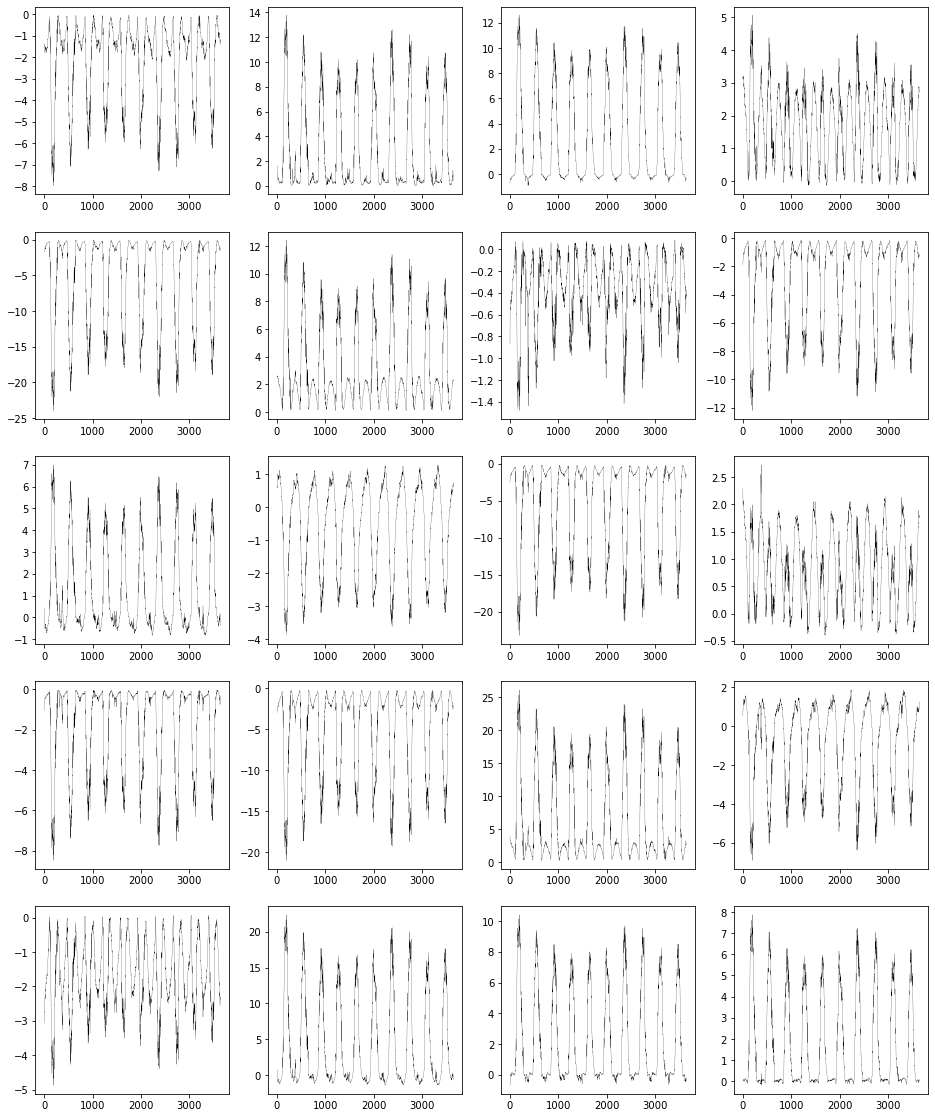

In [80]:
# start= 76*365
start= 0*365
b=b_c

# to_plot= projected[:4*365]
# to_plot= embedding_l[start:start+7*365]
to_plot= embedding_c[start:start+10*365]


fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
for i in range(b):
#     print(i%3, int(i/4))
    ax[int(i/4), i%4].plot(to_plot[:,i], 'k', linewidth=.2)

In [111]:
non_zero = np.var(np.array(embedding),axis=0)>0.1

In [114]:
non_zero.sum()

28

[0.9145522  0.9145522  0.87215877 0.87215877 0.9754213  0.8938443
 0.9092179  0.9092179  0.9209959  0.9209959  0.9326926  0.9326926
 0.93268484 0.93268484 0.93745506 0.93745506 0.9083187  0.9083187
 0.9245227  0.9245227 ]


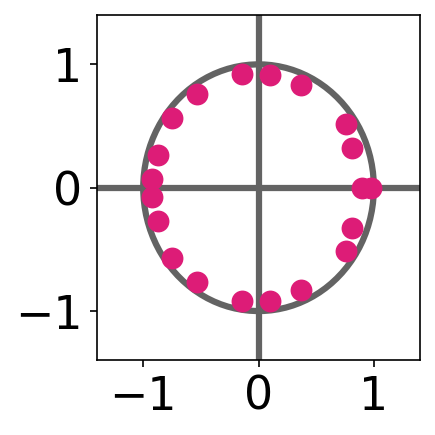

In [35]:
    #******************************************************************************
    # Eigenvalues
    #******************************************************************************
    model.eval()

    #if hasattr(model.dynamics, 'dynamics'):
    A =  model.dynamics.dynamics_l.weight.cpu().data.numpy()
    #A =  model.module.test.data.cpu().data.numpy()
    w, v = np.linalg.eig(A)
    print(np.abs(w))

    fig = plt.figure(figsize=(3, 3), facecolor="white",  edgecolor='k', dpi=150)
    plt.scatter(w.real, w.imag, c = '#dd1c77', marker = 'o', s=15*6, zorder=2, label='Eigenvalues')

    maxeig = 1.4
    plt.xlim([-maxeig, maxeig])
    plt.ylim([-maxeig, maxeig])
    plt.locator_params(axis='x',nbins=4)
    plt.locator_params(axis='y',nbins=4)

    #plt.xlabel('Real', fontsize=22)
    #plt.ylabel('Imaginary', fontsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.tick_params(axis='x', labelsize=22)
    plt.axhline(y=0,color='#636363',ls='-', lw=3, zorder=1 )
    plt.axvline(x=0,color='#636363',ls='-', lw=3, zorder=1 )

    #plt.legend(loc="upper left", fontsize=16)
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), ls='-', lw=3, c = '#636363', zorder=1 )
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.close('all')

In [279]:
np.angle(w)/np.pi

array([ 9.7641224e-01, -9.7641224e-01,  9.9486589e-01, -9.9486589e-01,
        9.9667752e-01, -9.9667752e-01,  9.9851018e-01, -9.9851018e-01,
        9.9971426e-01, -9.9971426e-01,  9.9973077e-01, -9.9973077e-01,
        6.9622928e-03, -6.9622928e-03,  0.0000000e+00,  2.9170753e-03,
       -2.9170753e-03,  3.0126562e-03, -3.0126562e-03,  0.0000000e+00,
        0.0000000e+00,  5.9229968e-04, -5.9229968e-04,  0.0000000e+00],
      dtype=float32)

In [12]:
len(train_data)

40178

In [13]:
type(train_data[:][0])

torch.Tensor

In [16]:
train_data[:][0][0].shape

torch.Size([1, 72, 144])

In [51]:
mean = torch.mean(torch.mean(torch.mean(train_data[:][0], axis=1),axis=1),axis=1)

## Compare reconstruction

In [91]:
train_data[:][0][0].shape

torch.Size([1, 144, 144])

In [93]:
np.array(train_data[:][0][0])[0][:72].shape

(72, 144)

In [81]:
import netCDF4

climate_file = netCDF4.Dataset('../../data/tas_ann_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')

In [82]:
lats = np.array(climate_file.variables['lat'])[::int(1/scale)]
lons = np.array(climate_file.variables['lon'])[::int(1/scale)]

In [42]:
index =1000

with torch.no_grad():
    # _,list_x_c = model.encoder(train_data[:][0][index:index +1])
    reconstruction = model(train_data[:][0][index:index +1], mode='reconstruct')[0]
# reconstruction = out[-1][0]
# reconstruction_forward = out[0][0]
# reconstruction_forward2 = out[1][0]


limit =int(72*scale)

plot_climate_data(temperature= np.array(train_data[:][0][index])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
plot_climate_data(temperature= np.array(reconstruction)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
if False:
    plot_climate_data(temperature= np.array(train_data[:][0][index +freq])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(reconstruction_forward)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(train_data[:][0][index + 2*freq])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(reconstruction_forward2)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)

    plot_climate_data(temperature= np.array(reconstruction_forward)[0][:limit] - np.array(reconstruction)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-0.5, max_temp=0.5, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(train_data[:][0][index + freq])[0][:limit] - np.array(train_data[:][0][index])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-0.5, max_temp=0.5, savefile=False, filename=None)

ValueError: expected 4D input (got 3D input)

In [224]:
np.array(reconstruction_forward2)[0]

array([[-0.00318271, -0.00076549, -0.00304498, ..., -0.0043342 ,
        -0.00463902, -0.00313249],
       [ 0.00238361, -0.00128422,  0.00282587, ...,  0.00203926,
        -0.00104515,  0.00037125],
       [-0.00109032, -0.00136732,  0.00285247, ...,  0.00091385,
         0.00061878, -0.00261519],
       ...,
       [ 0.00201057,  0.0030175 ,  0.00783203, ..., -0.00195522,
         0.00312627,  0.00050036],
       [ 0.00151684,  0.00316413,  0.00501444, ...,  0.00338816,
         0.00347363, -0.00593669],
       [ 0.01002446,  0.00693926,  0.00623682, ...,  0.00691448,
         0.00683182,  0.00057899]], dtype=float32)

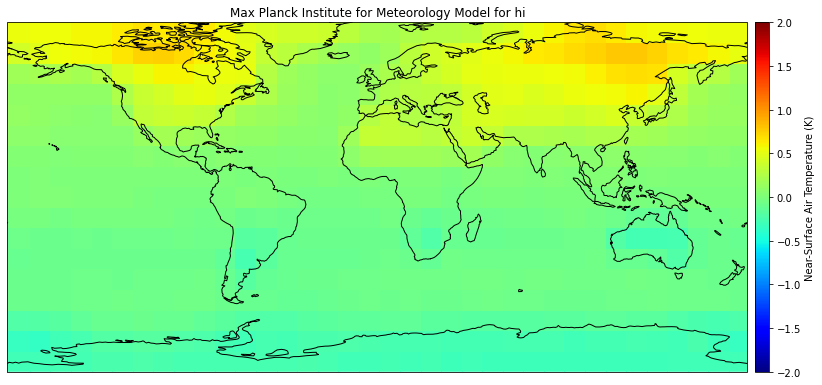

In [281]:
plot_climate_data(temperature= np.array(reconstruction_forward2)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)

In [223]:
len(out)

13

In [226]:
reconstruction_forward2.shape

torch.Size([1, 36, 36])